In [1]:
%gui qt
%matplotlib inline
from PIL import Image
from csbdeep.utils import Path, normalize
from glob import glob
from importlib import reload 
from magicgui import magicgui
from magicgui.widgets import Label, SpinBox, PushButton, Text, Container
from manager.acquisition import acq, acq_stim, acq_multi, acq_multi_dark, acq_mask
from manager.dmd import dmd
from manager.fov import FOV
from manager.preset import preset
from manager.stage import load_pos_file, get_pos_from_mm, stage_position
from matplotlib import pyplot as plt 
from multiprocessing import Process
from napari.layers import Image, Labels
from napari.qt import thread_worker
from pipeline.pipeline_single_frame import add_frame
from pipeline.stimulation import stim_random
from pycromanager import Acquisition, multi_d_acquisition_events
from pycromanager import Bridge
from addons.semantic_segmentation import init_VGG16_pyramid, fd_VGG16_pyramid
from skimage import io
from skimage.color import label2rgb
from skimage.measure import regionprops_table
from skimage.morphology import square
from skimage.segmentation import expand_labels
from sklearn.ensemble import RandomForestClassifier
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from tqdm import tqdm
from addons.utils import create_folders
from datetime import date
from datetime import datetime
from addons.tools import spot_mask_from_labels
from addons.tools import get_next_experiment_number
from addons.tools import migration_mask
from cellpose import models
from addons.value import variables_input
from addons.offset import offsetting
from addons import stim
from addons.mail import send_mail
import cv2
import gc
import glob
import importlib.util
import math
import matplotlib
import matplotlib.pyplot as plt
import napari
import nest_asyncio
import numpy as np
import os
import pandas as pd
import pickle as pkl
import queue
import scipy
import skimage
import threading
import time
import trackpy as tp
import os.path

#matplotlib.rcParams["image.interpolation"] = None
nest_asyncio.apply()



c:\Users\micro-manager\anaconda3\envs\joelEnv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\micro-manager\anaconda3\envs\joelEnv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.14.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not 

## Setup connection with micro manager

In [2]:
bridge = Bridge() #connection to micro-manager
core = bridge.get_core()
studio = bridge.get_studio()
print(bridge.get_core())
dmd = dmd(core) #init dmd device

violet 395  1 ao25 
blue   440  2 ao24 
cyan   470  3 ao22 
teal   508  7 ao12 
green  555 10 ao26 (not in NIS)
red    640 14 ao11 (not in NIS)


In [3]:
nidaq_setup = preset(core) #focus preset
nidaq_setup.settings = [

    ["Spectra RIGHT","Teal_Level",100],
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Level",100],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Level",100],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Level",100],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Level",100],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Level",100],
    ["Spectra RIGHT","Red_Enable",0],

    ["Spectra RIGHT","White_Enable",0],
    ['Andor sCMOS LEFT','AuxiliaryOutSource (TTL I/O)','FireAny']
]
nidaq_setup.apply_no_retry()

camera_setup = preset(core) #focus preset
camera_setup.settings = [
    ["Andor sCMOS LEFT","Binning",'2x2'],
    #["Andor sCMOS LEFT","Sensitivity/DynamicRange",'12-bit (low noise)'],
    #["Andor sCMOS LEFT","Exposure",'300'],
    #["Andor sCMOS LEFT","TriggerMode",'Software (Recommended for Live Mode)'],
    ["TILightPath","State",'2'],
    ["Mosaic3","TriggerMode",'InternalExpose'], #InternalSoftware
    #["Andor sCMOS LEFT","PixelReadoutRate",'200 MHz - lowest noise'],
]

camera_setup.apply(core)

Andor sCMOS LEFT: Set Binning to 2x2
TILightPath: Set State to 2
Mosaic3: Set TriggerMode to InternalExpose


In [4]:
black = preset(core)
black.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],
    ["Wheel-C", "State", 0],
]
black.apply()

## Create channel presets
#### Labels for state devices in micro-manager:
TIFilterBlock1  
0: empty  
1: 86000v2 - Sedat Quad  
2: 59222 - GFP/mCherry - ET  
3: 69308 - CFP/YFP/mCherry - ET  
4: 470lp  
5: zt 442/514/561  

Wheel-C:  
0: empty  
1: 84000v2 - DAPI/FITC/TRITC/Cy5 (Em1)  
2: 59022 - GFP/mCherry - ET (Em)  
3: CFP 458-482 (Ex)  
4: YFP 520-550 (Ex)  
5: CFP 460-500 (Ex)  
6-9: empty  

Spectra Colors:  
Blue (440), Cyan (bright blue 470), Green (yellow), Red, Teal (green/blue 508), Violet (359), White

mRuby2:
555/25 filter in lumencore
DM 1
Wheel-C 1


In [26]:
mruby2 = preset(core)
# 555/25 filter in lumencore
mruby2.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],

    ["TIFilterBlock1", "State", "1"],#2 
    ["Wheel-C", "State", 1],# could also use 1 # standard  2
    ["Spectra RIGHT","Green_Enable",1],
    ["Spectra RIGHT","Green_Level",20] #25
]
mruby2.camera_exposure_time = 400 #150
mruby2.dmd_exposure_time = 100
mruby2.name = "mRuby2 / ERK-KTR"

mruby2.apply(core)
dmd.all_on()

Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Cyan_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 1
Wheel-C: Set State to 1
Spectra RIGHT: Set Green_Enable to 1
Spectra RIGHT: Set Green_Level to 20


Worker started: append_img


In [23]:
mCherry = preset(core)
# 555/25 with same filterwheel as H2B or 575 with 2/2
mCherry.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],

    ["TIFilterBlock1", "State", "2"],#2 
    ["Wheel-C", "State", 2],# could also use 1 # standard  2
    ["Spectra RIGHT","Green_Enable",1],
    ["Spectra RIGHT","Green_Level",20] #25
]
mCherry.camera_exposure_time = 400 #150
mCherry.dmd_exposure_time = 100
mCherry.name = "mCherry / ERK-KTR"

mCherry.apply(core)
dmd.all_on()

Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Cyan_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 1
Wheel-C: Set State to 1
Spectra RIGHT: Set Green_Enable to 1
Spectra RIGHT: Set Green_Level to 20


Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img


In [6]:
miRFP = preset(core)
miRFP.settings = [
    ["TIFilterBlock1", "State", "1"],
    ["Wheel-C", "State", 1],
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],

    ["Spectra RIGHT","Red_Enable",1],
    ["Spectra RIGHT","Red_Level",100]
]
miRFP.camera_exposure_time = 500
miRFP.dmd_exposure_time = 150
miRFP.name = "miRFP"
miRFP.apply()
dmd.all_on()

In [7]:
OPTO_cal = preset(core) #mCitrine
OPTO_cal.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],

    ["TIFilterBlock1", "State", "1"],#2
    ["Wheel-C", "State", 0],#4 #1
    ["Spectra RIGHT","White_Level",0],
    ["Spectra RIGHT","Cyan_Enable",1], #should be cyan instead of TEAL which worked tho [green, ti=3, cw=1 \\ cyan ti=2,cw=1]
    ["Spectra RIGHT","Cyan_Level",40]
]
OPTO_cal.camera_exposure_time = 400 #100ms for 40x 
OPTO_cal.dmd_exposure_time = 100
OPTO_cal.name = "OPTO_cal"
OPTO_cal.apply(core)
dmd.checker_board()

Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 1
Wheel-C: Set State to 0
Spectra RIGHT: Set White_Level to 0
Spectra RIGHT: Set Cyan_Enable to 1
Spectra RIGHT: Set Cyan_Level to 40


In [8]:
#CHECK EXPRESSION OF OPTOGENETIC CONSTRUCT
OPTO_capture = preset(core) #mCitrine
OPTO_capture.settings = [
    ["Spectra RIGHT","Teal_Enable",1],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],
    ["TIFilterBlock1", "State", "5"],#2
    ["Wheel-C", "State", 4],#4 #1 #2
    ["Spectra RIGHT","White_Level",0],
    ["Spectra RIGHT","Cyan_Enable",0], #should be cyan instead of TEAL which worked tho [green, ti=3, cw=1 \\ cyan ti=2,cw=1]
    ["Spectra RIGHT","Teal_Level",100]
]
OPTO_capture.camera_exposure_time = 2000 #100ms for 40x 
OPTO_capture.dmd_exposure_time = 2000
OPTO_capture.name = "514-zt mCitrine"
OPTO_capture.apply(core)
#dmd.checker_board()
dmd.all_on()

Spectra RIGHT: Set Teal_Enable to 1
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 5
Wheel-C: Set State to 4
Spectra RIGHT: Set White_Level to 0
Spectra RIGHT: Set Cyan_Enable to 0
Spectra RIGHT: Set Teal_Level to 100


In [9]:
mNeonGreen = preset(core)

#Excitation: 475-510 (Cyan: 470)
#Emission: 510-550

# 555/25 with same filterwheel as H2B or 575 with 2/2
mNeonGreen.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],

    ["TIFilterBlock1", "State", "3"],#2 
    ["Wheel-C", "State", 4],# could also use 1 # standard  2
    ["Spectra RIGHT","Cyan_Enable",1],
    ["Spectra RIGHT","Cyan_Level",25] #25
]
mNeonGreen.camera_exposure_time = 250 #150
mNeonGreen.dmd_exposure_time = 100
mNeonGreen.name = "mNeonGreen"

mNeonGreen.apply(core)
dmd.all_on()


Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 3
Wheel-C: Set State to 4
Spectra RIGHT: Set Cyan_Enable to 1
Spectra RIGHT: Set Cyan_Level to 25


In [10]:
black = preset(core)
black.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],
    ["Wheel-C", "State", 0],
]
black.apply()

# NAPARI LIVEVIEW

In [11]:
#channels = [H2B_capture, ERK_capture, OPTO_capture]#OPTO_stim  , OPTO_cal OPTO_capture
channels = [miRFP,mruby2,OPTO_cal,OPTO_capture,mNeonGreen]

#Excitation: 475-510 (Cyan: 470)
#Emission: 510-550

# 555/25 with same filterwheel as H2B or 575 with 2/2
mNeonGreen.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],

    ["TIFilterBlock1", "State", "3"],#2 
    ["Wheel-C", "State", 4],# could also use 1 # standard  2
    ["Spectra RIGHT","Cyan_Enable",1],
    ["Spectra RIGHT","Cyan_Level",25] #25
]
mNeonGreen.camera_exposure_time = 250 #150
mNeonGreen.dmd_exposure_time = 100
mNeonGreen.name = "mNeonGreen"

mNeonGreen.apply(core)
dmd.all_on()


Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 3
Wheel-C: Set State to 4
Spectra RIGHT: Set Cyan_Enable to 1
Spectra RIGHT: Set Cyan_Level to 25


Creates folder to save images made in Napari.

Change path "parent_folder" to the folder where all the experiments are stored.

Change path "output_path" to the experiment folder, number will be calculated automatically.

In [12]:
# function to store image
parent_folder = 'Z:\\jfrei\\Data\\experiments\\'
folder_nb = get_next_experiment_number(parent_folder)
output_path = f'Z:\\jfrei\\Data\\experiments\\exp_{folder_nb}\\'
required_folders = ['Images']
create_folders(output_path,required_folders)

Directory Z:\jfrei\Data\experiments\exp_44\Images created 


In [13]:
image_nb = 0
def acquire_single_frame(output_path,image_nb):
    global zmq_lock
    zmq_lock.acquire()
    time.sleep(.5)
    image = acq(core)
    zmq_lock.release()
    time.sleep(.5)

    fname = f'{str(image_nb).zfill(2)}'
    
    io.imsave(output_path+'Images\\'+fname+'.tiff',image, check_contrast=False)
    image_nb += 1
    return image_nb
    

In [14]:
# data acquired on microscope or simulated?
simulate = False
clip =[1024, 1024]
# um / px, for correct scaling in napari
size_um = [0.16, 0.16]
#Time between checking again if new image is available
sleep_time = 0.05
# contrast limits for display
clim = [0, 300]
# initialize global variables
# flag to break while loops
acq_running = False
# empty queue for image data\ and z positions
img_queue = queue.Queue()
# xyz data stack
data = np.random.rand(clip[0], clip[1]) * clim[1]
zmq_lock = threading.Lock()
position_list = []

In [15]:
import cv2
import time
font = cv2.FONT_HERSHEY_DUPLEX
checker_board = np.kron([[1, 0] * 20, [0, 1] * 20] * 20, np.ones((20, 20))) #https://stackoverflow.com/a/37440123
startup_screen = checker_board*100
cv2.putText(startup_screen,'github.com/hinderling',(40,780), font, 2,(255),2)
#plt.imshow(startup_screen)
data = startup_screen
image_nb = 0

def acquire_data_single_frames():
    global zmq_lock
    zmq_lock.acquire()
    image = acq(core)
    zmq_lock.release()
    
    #print('run grab_image')
    place_data(image)
    
def acquire_data():
    global channels
    global img_queue

    #array = live_manager.snap(False)
    zmq_lock.acquire()
    remaining_image_count = core.get_remaining_image_count()
    zmq_lock.release()
    if remaining_image_count < 1:
        print('No image in uManager queue.')
        time.sleep(0.5)
        return
    
    zmq_lock.acquire()
    array = core.get_last_image()
    #core.clear_circular_buffer()
    zmq_lock.release()
    img_width = int(math.sqrt(len(array)))
    img = np.reshape(array, (img_width,img_width))
    img = img[:,:]
    img_queue.put([channels[1], img])
    return

def acquire_data_single_frames():
    global zmq_lock
    zmq_lock.acquire()
    image = acq(core)
    zmq_lock.release()
    
    #print('run grab_image')
    place_data(image)
    
def acquire_data():
    global channels
    global img_queue

    #array = live_manager.snap(False)
    zmq_lock.acquire()
    remaining_image_count = core.get_remaining_image_count()
    if remaining_image_count < 1:
        zmq_lock.release()
        #print('Warning: No image in uManager queue.')
        time.sleep(0.5)
        return
    try:
        array = core.get_last_image()
    except:
        print('ERROR: No image in uManager queue.')
        time.sleep(0.5)
        return

    zmq_lock.release()
    img_width = int(math.sqrt(len(array)))
    img = np.reshape(array, (img_width,img_width))
    img = img[::,::] #LUCIEN CHANGED IT DROM ::2
    img_queue.put([channels[1], img])
    return

def display_napari(image):
    """ Unpacks z position and reshapes image from pos_img. Writes image into correct
        slice of data, and updates napari display.
        Called by worker thread yielding elements from queue.
        Needs to be in code before worker thread connecting to it.
        Inputs: array pos_img: queue element containing z position and raveled image data.
        Global variables: np.array data: contains image stack
            img_queue: needed only to send task_done() signal.
    """
    global data
    global img_queue
    channel = image[0]
    image= image[1]
    layers[0].data = image
    img_queue.task_done()

@thread_worker
def append_img(img_queue):
    """ Worker thread that adds images to a list.
        Calls either micro-manager data acquisition or functions for simulating data.
        Inputs: img_queue """

    # start microscope data acquisition
    print('Worker started: append_img')
    if not simulate:
         while acq_running:
            acquire_data()
            time.sleep(sleep_time)

    # run with simulated data
    else:
        ii = 0
        while acq_running:
            simulate_data(ii)
            ii = ii + 1
            time.sleep(sleep_time)


@thread_worker(connect={'yielded': display_napari})
def yield_img(img_queue):
    """ Worker thread that checks whether there are elements in the
        queue, reads them out.
        Connected to display_napari function to update display """
    global acq_running
    
    #time_last_frame = time.time()
    #print('yield image')
    
    #print(acq_running)
    while acq_running:
        #time.sleep(sleep_time)
        # get elements from queue while there is more than one element
        # playing it safe: I'm always leaving one element in the queue
        img_queue_size = img_queue.qsize()
        #print(img_queue_size)
        while img_queue.qsize() > 0:
            #print("reading from queue ", img_queue.qsize())
            yield img_queue.get(block = False)
            #time_this_frame = time.time()
            #time_diff = time_this_frame - time_last_frame
            #fps = int(1/time_diff)
        time.sleep(sleep_time)

    # read out last remaining elements after end of acquisition
    while img_queue.qsize() > 0:
        yield img_queue.get(block = False)
@magicgui(call_button = "Start")
def start_acq():
    """ Called when Start button in pressed. Starts workers and resets global variables"""
    global acq_running
    global channels
    global zmq_lock
    if not acq_running:
        #z_range[3] = 0
        acq_running = True
        zmq_lock.acquire()
        core.start_continuous_sequence_acquisition(0)
        zmq_lock.release()
        worker1 = append_img(img_queue)
        worker2 = yield_img(img_queue)
        worker1.start()
        #worker2.start() # doesn't need to be started bc yield is connected
    else:
        print("acquisition already running!")

threshold = 100

@magicgui(slider_float={"widget_type": "FloatSlider", 'max': 1000})
def set_treshold(slider_float=100):
    global threshold
    threshold = slider_float

@magicgui(call_button = "Stop")
def stop_acq():
    # set global acq_running to False to stop other workers
    global acq_running
    global core
    global zmq_lock
    
    zmq_lock.acquire()
    core.stop_sequence_acquisition()    
    zmq_lock.release()
    acq_running = False

    
#a channel is a preset that has EXPOSURE and POWER function
channels_widget = Container()
channels_widgets_list = []
for channel in channels:
    @magicgui(
    call_button = 'SELECT',
    auto_call=False,
    label = {"widget_type": "Label","name":"label","label":channel.name},
    power={"widget_type": "SpinBox","name":"power" ,"label":'%',"min":0,"max": 100},
    exposure={"widget_type": "SpinBox","name":"ms" ,"label":'ms',"min":1,"max": 10000},
    #mode={"choices": ["reflect", "constant", "nearest", "mirror", "wrap"]},
    layout='horizontal',
    channel={'bind': channel} #replace this with channel 
    )
    def channel(label, power: int = channel.settings[-1][2], exposure=channel.camera_exposure_time, channel = channel):
        global channels
        #print(channel.name)
        stop_acq()
        channel.camera_exposure_time = exposure
        channel.set_power(power)
        zmq_lock.acquire()
        channel.apply()
        dmd.all_on()
        zmq_lock.release()
        start_acq()
    channels_widgets_list.append(channel)

channels_widget = Container(widgets=(channels_widgets_list))


@magicgui(call_button = "Store position")
def store_pos():
    global channels
    global zmq_lock
    global acq_running
    global position_list
    
    restart = False
    if acq_running:
        stop_acq()
        time.sleep(.5)
        restart = True
    zmq_lock.acquire()
    time.sleep(.5)
    point = core.get_xy_stage_position()
    pfs_offset = core.get_auto_focus_offset()
    x = point.get_x()
    y = point.get_y()
    zmq_lock.release()
    time.sleep(.5)
    position_list.append(stage_position(x,y,pfs_offset))
    if restart:
        start_acq()    

@magicgui(call_button = "Save Image")
def store_img():
    global acq_running
    global core
    global image_nb
    restart = False

    if acq_running:
        stop_acq()
        restart = True
        
    image_nb = acquire_single_frame(output_path,image_nb)

    if restart:
        start_acq()
        
# check if viewer is already open
# if yes: close and reopen
try:
    if viewer:
        viewer.close()
except:
    print("viewer already closed or never opened")
viewer = napari.Viewer(ndisplay=2)

# initialize napari viewer with stack view and random data, reslice view
#scale = [(z_range[1]-z_range[0])/z_range[2]*z_scale, size_um[1], size_um[0]]
layers = [viewer.add_image(data,
                        name = 'zero',
                        colormap = 'gray',
                        interpolation = 'nearest',
                        blending = 'additive',
                        rendering = 'attenuated_mip',
                        #scale = scale,
                        contrast_limits = clim)
         ]

#viewer.dims._roll()
viewer.window.add_dock_widget(start_acq,area='left')
viewer.window.add_dock_widget(stop_acq,area='left')
viewer.window.add_dock_widget(channels_widget,area='left') 
viewer.window.add_dock_widget(store_pos,area='left')
viewer.window.add_dock_widget(store_img, area='left')
viewer.text_overlay.visible = True
#viewer.window.qt_viewer.canvas.measure_fps(callback=update_fps)    

viewer already closed or never opened


2200540280.py (263): Argument 'interpolation' is deprecated, please use 'interpolation2d' instead. The argument 'interpolation' was deprecated in 0.4.17 and it will be removed in 0.6.0.


In [ ]:
len(position_list)

print(position_list)

[]


## Preview the channel settings

In [27]:
channels_to_acq = [mruby2,miRFP]# ,OPTO_cal]#, OPTO_cal]#OPTO_stim  , OPTO_cal
frame = acq_multi(channels_to_acq,dmd)
plt.figure(figsize = (10,5),dpi = 300)
fig, axs = plt.subplots(2, len(channels_to_acq), figsize = (10,10),dpi = 300)
fig.suptitle('Acquisition settings preview')
#dark_frame = acq_multi_dark(channels_to_acq,dmd)
#frame = frame + dark_frame*-1
for channel_nb, channel in enumerate(channels_to_acq):
    axs[0][channel_nb].imshow(frame[channel_nb,:,:])
    axs[0][channel_nb] = channel.name
for channel_nb, channel in enumerate(channels_to_acq):
    flat = frame[channel_nb,:,:].flatten()
    axs[1][channel_nb].hist(flat, bins=150, range=(0, 65535/10))
plt.tight_layout()
plt.show()


Exception: java.lang.Exception: This operation can not be executed while sequence acquisition is running.
mmcorej.MMCoreJJNI.CMMCore_snapImage(Native Method)
mmcorej.CMMCore.snapImage(CMMCore.java:928)
sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
java.lang.reflect.Method.invoke(Method.java:498)
org.micromanager.internal.zmq.ZMQServer.runMethod(ZMQServer.java:346)
org.micromanager.internal.zmq.ZMQServer.parseAndExecuteCommand(ZMQServer.java:401)
org.micromanager.internal.zmq.ZMQServer.lambda$initialize$1(ZMQServer.java:108)
java.util.concurrent.FutureTask.run(FutureTask.java:266)
java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
java.lang.Thread.run(Thread.java:748)


: 

In [18]:
#io.imsave('/Users/micro-manager/Desktop/star_pattern_temp_2.tif',frame)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


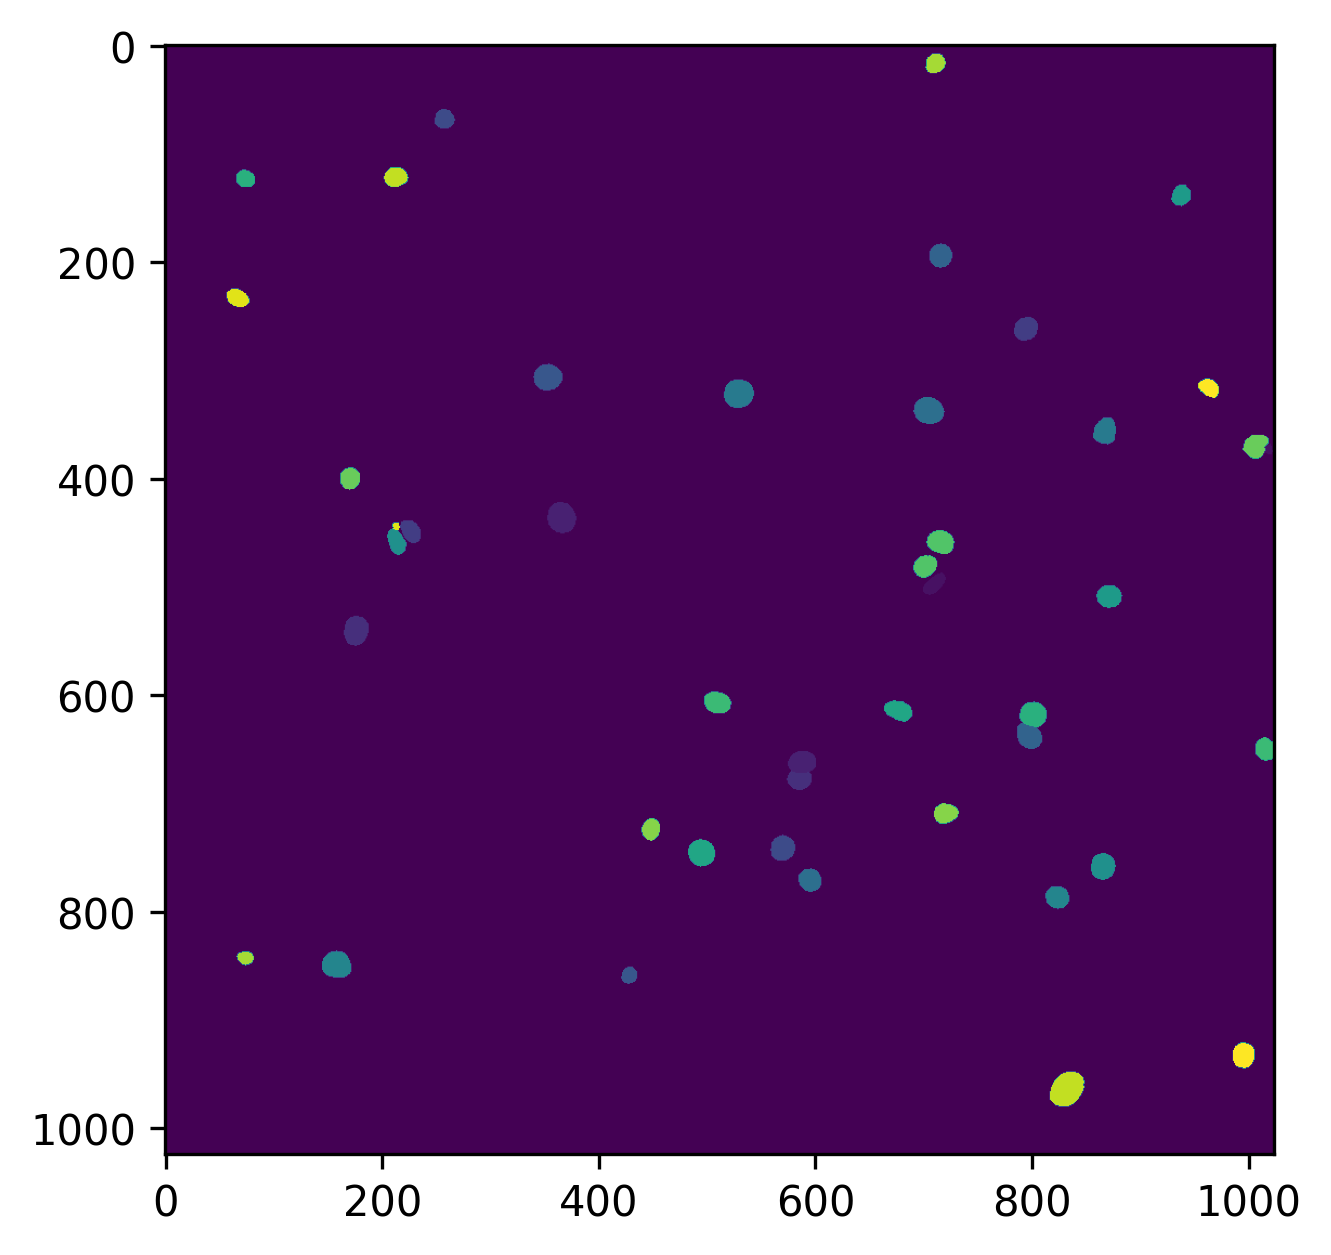

found 46 cells


In [19]:
norm_min = 1
norm_max = 99
stardist_model = StarDist2D.from_pretrained('2D_versatile_fluo')

from csbdeep.utils import Path, normalize
from skimage.morphology import remove_small_objects

## PREPROCESSING ##   
#scale the h2b channel for so StarDist
f_h2b = frame[1,:,:].copy()
f_h2b_scaled = normalize(f_h2b, norm_min,norm_max) #30 95

##Instance segmentation
#https://github.com/stardist/stardist/blob/master/stardist/models/base.py
labels, details = stardist_model.predict_instances(f_h2b_scaled)
# remove small objects:
labels = remove_small_objects(labels, min_size=30, connectivity=1)
plt.figure(dpi=300)
plt.imshow(labels%23)
plt.show()
print(f'found {len(np.unique(labels))} cells')

## Migration mask preview

In [20]:

from addons.tools import migration_mask
from cellpose import models
f_erk_prev = frame[0,:,:].copy()
light_map_preview, cellpose_mask = migration_mask(f_erk_prev, 'y-axis', 25, 5, 'surface', 'down-left')

viewer.add_labels(light_map_preview)
viewer.add_labels(cellpose_mask)

<Labels layer 'cellpose_mask' at 0x1836670f310>

In [23]:

output_path = f'Z:\\jfrei\\Data\\experiments\\exp_{folder_nb}\\'
#output_path = 'c:\\Users\\micro-manager\\Desktop\\temp_joel\\'

required_folders = ['extra']
create_folders(output_path,required_folders)

io.imsave(output_path+'extra\\'+'cellpose'+'.tiff',cellpose_mask, check_contrast=False)
io.imsave(output_path+'extra\\'+'migration_mask'+'.tiff',light_map_preview, check_contrast=False)
io.imsave(output_path+'extra\\'+'frame'+'.tiff',f_erk_prev, check_contrast=False)

Directory Z:\jfrei\Data\experiments\exp_36\extra created 


## Calibrate the DMD for the stimulation channel

Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 1
Wheel-C: Set State to 0
Spectra RIGHT: Set White_Level to 0
Spectra RIGHT: Set Cyan_Enable to 1
Spectra RIGHT: Set Cyan_Level to 40


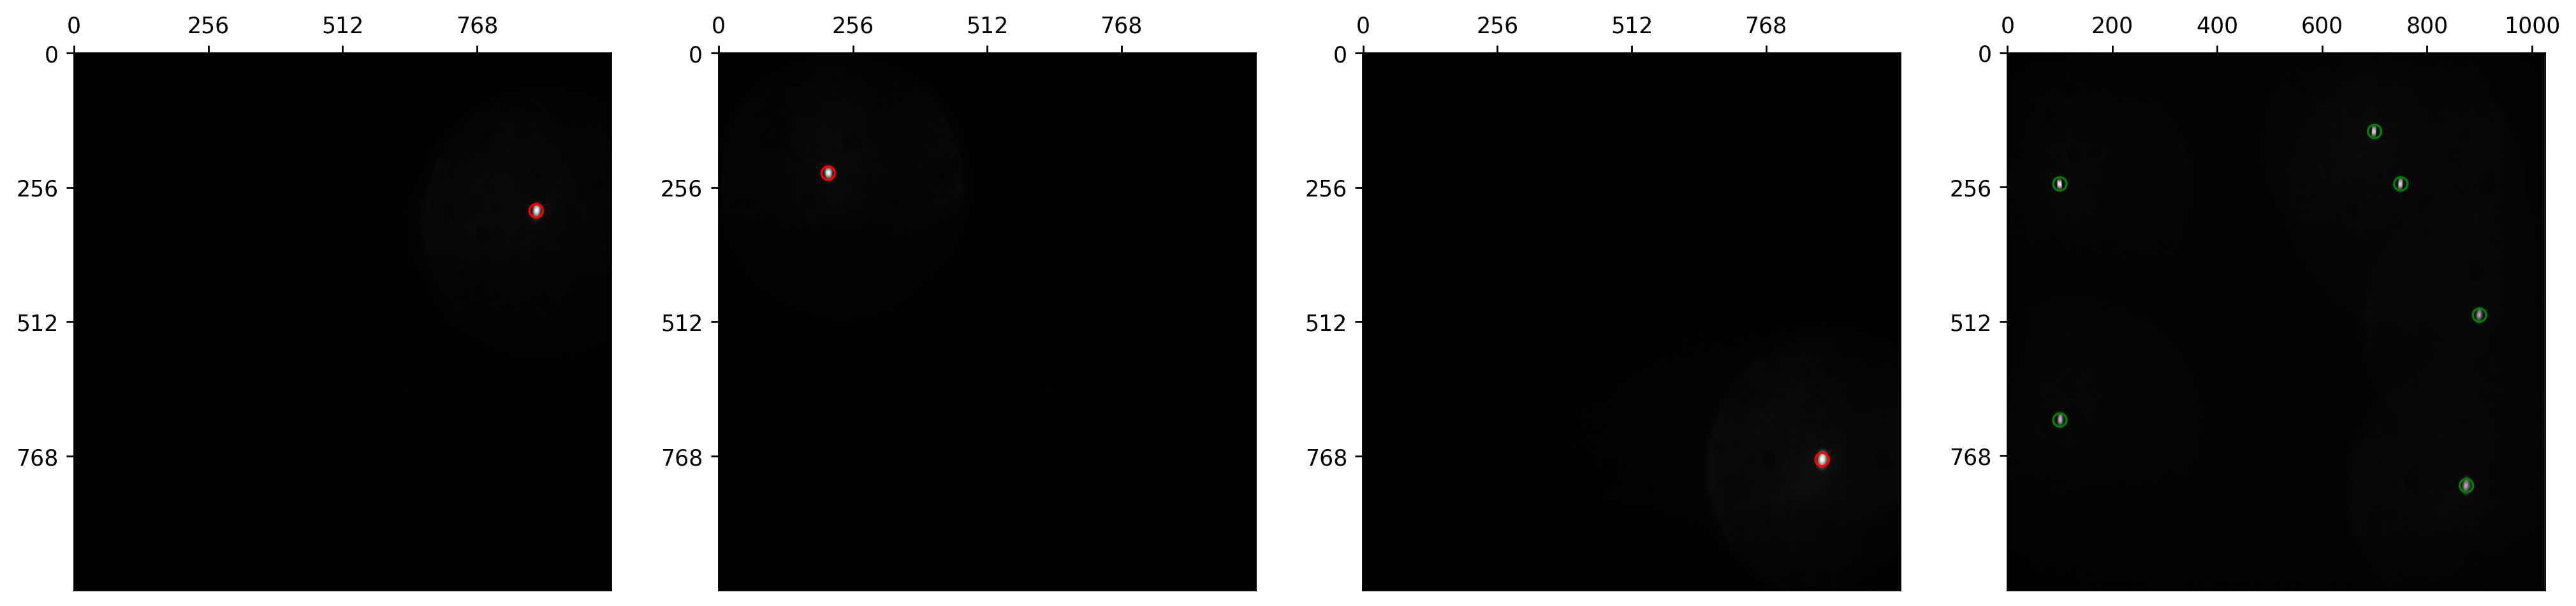

In [29]:
OPTO_cal.apply(core)
affine = dmd.calibrate(verbous = True, blur = 6, circle_size = 5, marker_style = 'o')

#np.save(("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_20x_2bin_white.npy"), affine)
#np.save(("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_20x_2bin_OPTO_STIM.npy"), affine)

In [19]:
affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_20x_2bin_OPTO_STIM_00.npy")

In [20]:
np.save(("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_40x_induce_apo.npy"), affine)

In [21]:
affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_40x_induce_apo.npy")

## Load affine transformation matrix from disk

In [25]:
affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_40x_2bin_OPTO_STIM.npy")
affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_20x_2bin_OPTO_STIM.npy")


## Load micro-manager POS from live MM session

In [24]:
#### STORE
import pickle
with open('C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\pos_list_26.pkl', "wb") as fp:   #Pickling
    pickle.dump(position_list, fp)

In [16]:
#### LOAD
import pickle

with open('C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\pos_list_26.pkl', "rb") as fp:   #Pickling
    position_list = pickle.load(fp)

## Display the positions and travel paths

1


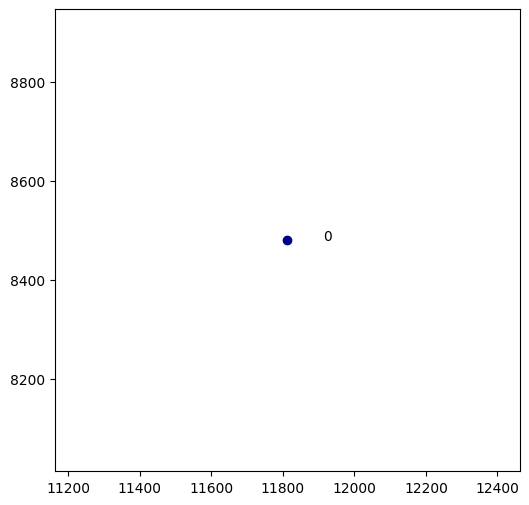

In [28]:
xs = []
ys = []
plt.figure(figsize= (6,6))
for i,pos in enumerate(position_list):
    plt.scatter(pos.x,pos.y,c ='darkblue')
    xs.append(pos.x)
    ys.append(pos.y)
    plt.text(pos.x+100, pos.y, str(i))
print(len(position_list))
plt.plot(xs,ys,c = 'darkblue',alpha = 0.2)
plt.show()

In [27]:
print(len(position_list))

del position_list[1]

print(len(position_list))


2
1


### Defines all values

Create stim regimes and multiply position list / stim regimes to desires number.

Change standards data: if no value is entered, the standard value will be automatically used.

Change "nb_total_fovs" to adapt the position list and stim regimes to desired number.

Stim diameter properties: 1. Local, 2. Global



Define all variables needed for experiment.

Change standards data: if no value is entered, the standard value will automatically be used.


In [36]:

## Enter new standards if desired
standards_data = [
    ["nb_parralel_fovs", 1, "fovs"],
    ["repeats", 4, "times"],
    ["pre_exp_waiting", 0, "minutes"],
    ["nb_time_steps", 115, "steps"],
    ["time_between_frames", 60, "seconds"]
    
]

standards_columns = ["Input", "Numeric Value", "Unit"]
standards_df = pd.DataFrame(standards_data, columns=standards_columns)

## Create input variables. New inputs can easily be added into list.
input_list = ["nb_parralel_fovs", "repeats", "pre_exp_waiting", "nb_time_steps", "time_between_frames"]
variable_dic = variables_input(input_list, standards_df)
print(variable_dic)

{'nb_parralel_fovs': 1, 'repeats': 6, 'pre_exp_waiting': 0, 'nb_time_steps': 115, 'time_between_frames': 60}
{'nb_parralel_fovs': 1, 'repeats': 6, 'pre_exp_waiting': 0, 'nb_time_steps': 115, 'time_between_frames': 60}
{'nb_parralel_fovs': 1, 'repeats': 6, 'pre_exp_waiting': 0, 'nb_time_steps': 115, 'time_between_frames': 60}


In [37]:
## Creates each variable from dictionary
for key, value in variable_dic.items():
    exec(f'{key} = {value}')
    print(key," = ",value)

nb_parralel_fovs  =  1
repeats  =  6
pre_exp_waiting  =  0
nb_time_steps  =  115
time_between_frames  =  60


In [30]:
stimulation_frame_list = []

In [32]:
stimulation_frame_list = [2,3,4,5]

In [14]:
result = [y + x for y in [9,29,49,69,89,109,129,149,169,189,209] for x in range(10)]
print(result)

[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218]


In [13]:
stim_list = [9,69,129,189]
result = [y + x for y in [9,69,129,189] for x in range(30)]
print(result)


[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218]


In [24]:
result = [x for x in range(9,200,2)]
print(result)

result = [x for x in range(9,200,5)]
print(result)

result = [y + x for y in [9,49,89,129,169] for x in range(20)]
print(result)

result = [x for x in range(9,200,10)]
print(result)


[9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199]
[9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199]
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 169, 170, 171, 172, 173, 174, 175, 176, 1

In [38]:
stim_regs = []

stim_reg_0 = {'percentage': 25,
                'axis': 'y-axis',
                'type':'outline',
                'direction':'up-right',
                'width' : 5,
                'duration' : 200,
                'intensity': 10,
                'stimulation_frame_list' : [x for x in range(9,100,2)] }

stim_reg_1 = {'percentage': 25,
                'axis': 'y-axis',
                'type':'outline',
                'direction':'down-left',
                'width' : 5,
                'duration' : 200,
                'intensity': 10,
                'stimulation_frame_list' :[x for x in range(9,100,2)]}

stim_reg_2 = {'percentage': 100,
                'axis': 'y-axis',
                'type':'outline',
                'direction':'up-right',
                'width' : 5,
                'duration' : 200,
                'intensity': 10,
                'stimulation_frame_list' :[x for x in range(9,100,2)]}

stim_reg_3 = {'percentage': 25,
                'axis': 'y-axis',
                'type':'outline',
                'direction':'up-right',
                'width' : 5,
                'duration' : 200,
                'intensity': 10,
                'stimulation_frame_list' : [y + x for y in [9,49,89] for x in range(20)]}

stim_reg_4 = {'percentage': 25,
                'axis': 'y-axis',
                'type':'outline',
                'direction':'down-left',
                'width' : 5,
                'duration' : 200,
                'intensity': 10,
                'stimulation_frame_list' : [y + x for y in [9,49,89] for x in range(20)]}

stim_reg_5 = {'percentage': 100,
                'axis': 'y-axis',
                'type':'outline',
                'direction':'up-right',
                'width' : 5,
                'duration' : 200,
                'intensity': 10,
                'stimulation_frame_list' :[y + x for y in [9,49,89] for x in range(20)]}

stim_regimes = []
stim_regimes  = [stim_reg_0] * nb_parralel_fovs + [stim_reg_1] * nb_parralel_fovs + [stim_reg_2] * nb_parralel_fovs + [stim_reg_3] * nb_parralel_fovs + [stim_reg_4] * nb_parralel_fovs + [stim_reg_5] * nb_parralel_fovs

print(len(stim_regimes))

for x in range(len(stim_regimes)):
    print(stim_regimes[x])
    print('/n')

6
{'percentage': 25, 'axis': 'y-axis', 'type': 'outline', 'direction': 'up-right', 'width': 5, 'duration': 200, 'intensity': 10, 'stimulation_frame_list': [9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]}
/n
{'percentage': 25, 'axis': 'y-axis', 'type': 'outline', 'direction': 'down-left', 'width': 5, 'duration': 200, 'intensity': 10, 'stimulation_frame_list': [9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]}
/n
{'percentage': 100, 'axis': 'y-axis', 'type': 'outline', 'direction': 'up-right', 'width': 5, 'duration': 200, 'intensity': 10, 'stimulation_frame_list': [9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 8

In [45]:
stim_regs = []

stim_reg_0 = {'percentage': 25,
                'axis': 'y-axis',
                'type':'surface',
                'direction':'up-right',
                'width' : 5,
                'duration' : 200,
                'intensity': 10,
                'stimulation_frame_list' : [2,3,4,5] }


stim_regumes = []
stim_regimes  = [stim_reg_0] * nb_parralel_fovs 

print(len(stim_regimes))

for x in range(len(stim_regimes)):
    print(stim_regimes[x])
    print('/n')

10
{'percentage': 25, 'axis': 'y-axis', 'type': 'surface', 'direction': 'up-right', 'width': 5, 'duration': 200, 'intensity': 10, 'stimulation_frame_list': [2, 3, 4, 5]}
/n
{'percentage': 25, 'axis': 'y-axis', 'type': 'surface', 'direction': 'up-right', 'width': 5, 'duration': 200, 'intensity': 10, 'stimulation_frame_list': [2, 3, 4, 5]}
/n
{'percentage': 25, 'axis': 'y-axis', 'type': 'surface', 'direction': 'up-right', 'width': 5, 'duration': 200, 'intensity': 10, 'stimulation_frame_list': [2, 3, 4, 5]}
/n
{'percentage': 25, 'axis': 'y-axis', 'type': 'surface', 'direction': 'up-right', 'width': 5, 'duration': 200, 'intensity': 10, 'stimulation_frame_list': [2, 3, 4, 5]}
/n
{'percentage': 25, 'axis': 'y-axis', 'type': 'surface', 'direction': 'up-right', 'width': 5, 'duration': 200, 'intensity': 10, 'stimulation_frame_list': [2, 3, 4, 5]}
/n
{'percentage': 25, 'axis': 'y-axis', 'type': 'surface', 'direction': 'up-right', 'width': 5, 'duration': 200, 'intensity': 10, 'stimulation_frame_l

In [39]:
nb_total_fovs = 6

stim_regimes, position_list = stim.stim_pos_len_equalizer(stim_regimes, position_list, nb_total_fovs)

Length of the lists:  6 & 6


### Check Offset


## Initialize the FOVs from a position list


    '''2. Per-frame. Check Autofocus in the MDA windows, configure Autofocus to
    use PFSStatus, and make sure to turn off PFS on the microscope stand
    before starting. If using multiple XY positions, make sure to include
    the Z drive in the position list (see Kurt's explanation above).
    Including the PFSOffset in the position list is optional (include only
    if you want different offsets per position). 


    when I try to
    set the Z position with the setPosition function, the PFS is disabled and I
    have to reactivate it with enableContinuousFocus again.

    I have not worked with the Ti2, but with the Ti, this is baked into the
    microscope firmware: any movement of the Z-position disables the PFS.  I
    suspect that the same is true for the Ti2. Since you want the PFS
    activated in any case, can you simply skip the Z position movement, and
    rely on the PFS to establish the new position? 


    On: PFS is locked and actively correcting focus.
    Off: PFS is deactivated.
    DIS: PFS out of focus and not working. This could be due to sample out of focus, ilumination problem or impossibility to maintain PFS active. 
    ERR: An error occurred with the PFS, speak with the UIC personnel to help you.

    In the Autofocus properties window, select the microscope PFS with the name "TIPFSStatus" and set its status to "ON".
    '''

In [40]:
import pipeline

from importlib import reload
reload(pipeline)
from pipeline import pipeline_single_frame
from pipeline.pipeline_single_frame import add_frame

In [55]:
### Settings for pipeline REAL MODE ###
test_mode = False
#time_between_frames = 1*60 #in s
#nb_time_steps = int(40)
presets = [miRFP,mCherry]

table_old = None
stim_frame = False
search_range = 15
memory = 3
np.random.seed(6)
lbl_cmap = random_label_cmap()
output_path = f'Z:\\jfrei\\Data\\experiments\\exp_{folder_nb}\\'
#output_path = 'c:\\Users\\micro-manager\\Desktop\\temp_joel\\'


## Create the required folders
required_folders = ['light_mask','raw','mask','stim','tracks','opto_check','mask_ring','spots', 'cellpose_mask']
create_folders(output_path,required_folders)

Directory Z:\jfrei\Data\experiments\exp_37\light_mask created 
Directory Z:\jfrei\Data\experiments\exp_37\raw created 
Directory Z:\jfrei\Data\experiments\exp_37\mask created 
Directory Z:\jfrei\Data\experiments\exp_37\stim created 
Directory Z:\jfrei\Data\experiments\exp_37\tracks created 
Directory Z:\jfrei\Data\experiments\exp_37\opto_check created 
Directory Z:\jfrei\Data\experiments\exp_37\mask_ring created 
Directory Z:\jfrei\Data\experiments\exp_37\spots created 
Directory Z:\jfrei\Data\experiments\exp_37\cellpose_mask created 


In [42]:
def wait_function(fov, time_between_frames,experiment_start_time):
    #check the time since the last exposure
    #wait if its less than the temporal resolution we aim for

    current_time = time.time()-experiment_start_time #relative time since start of experiment

    if fov.last_frame_time != None: #not the first frame 
        #check if we need to wait
        time_scince_last_frame = current_time - fov.last_frame_time
        wait_time = time_between_frames-time_scince_last_frame
        if time_scince_last_frame > time_between_frames:
            # we're to slow.
            seconds_behind = (wait_time)*-1
            if seconds_behind > 5: # Hardware cannot keep up!
                print('Seconds behind: ' + str(round(seconds_behind,2)))
                print('Warning: Use less FOVs, set framerate cannot be achieved.') 
        else:
            # we're to fast. Wait the remaining time.
            print('Wait some time: ' + str(round(wait_time, 2)))
            time.sleep(wait_time)
            
    current_time = time.time()-experiment_start_time #relative time scince start of experiment
    fov.last_frame_time = current_time
    return

### Deinfe Lightmask migration mask

stim_regimes = []

stim_offsets = [(0,0),(2,20),(4,40)] # (y,x) +x --> left, -x --> right, +y --> down, -y --> up

for intensity in [10]:

    for duration in [20,100,500]:

        for stim_offset in stim_offsets:

            for stim_diameter in [4]:

                stim_regimes.append((intensity,duration,stim_offset,stim_diameter))

                print(intensity,duration,stim_offset,stim_diameter)
                
print(len(stim_regimes))

### Define function for changing the offset in different direction

In [43]:

import time
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time
import trackpy as tp
from PIL import Image
import cv2
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf
import skimage
from skimage.segmentation import expand_labels
from cellpose import models




def dose_response(table,frame_labeled, stim_regime, frame):
    last_frame = table['frame'].max()
    table_f = table[table['frame']==last_frame]
    if len(table_f['particle']) == 0:
        #no cells in this FOV!
        print('Warning: Empty FOV (no cells detected)')
        return [], np.zeros((1024,1024))
    
    props = skimage.measure.regionprops(frame_labeled)
    props[0].bbox[0]
    rows = [int(prop.centroid[0]) for prop in props] #(min_row, min_col, max_row, max_col)
    cols = [int(prop.centroid[1]) for prop in props] #(row, col).

    #coordinates = [[row-10,col] for row,col in zip(rows,cols)]
    coordinates = [[row,col] for row,col in zip(rows,cols)]
    #turn coordinates of centroids to light mask image

    current_axis = stim_regime['axis']
    current_percentage = stim_regime['percentage']
    current_width = stim_regime['width']
    current_type = stim_regime['type']
    current_direction = stim_regime['direction']

    light_mask, cellpose_mask = migration_mask(frame, current_axis, current_percentage, current_width, current_type, current_direction)


    frame_labeled_expanded = expand_labels(frame_labeled,10)
    light_mask_mod = np.logical_and(light_mask ,frame_labeled_expanded == 0)

    return table_f['label'].values, light_mask, cellpose_mask



In [44]:
from pipeline.pipeline_single_frame import extract_ring,extract_features

def add_frame(frame, fov, stardist_model, time_point, stim_frame, output_path, norm_min, norm_max, stim_regime):
    time_start = time.time()

    #name under which the images are stored
    fname = f'{str(fov.index).zfill(2)}_{str(time_point).zfill(5)}'

    ## PREPROCESSING ##   
    #scale the h2b channel for so StarDist
    f_h2b = frame[0,:,:].copy()
    f_h2b_scaled = normalize(f_h2b, norm_min,norm_max)

    ##Instance segmentation
    #https://github.com/stardist/stardist/blob/master/stardist/models/base.py
    labels, details = stardist_model.predict_instances(f_h2b_scaled)

    # remove small objects:
    labels = remove_small_objects(labels, min_size=50, connectivity=1) # min_size to filter out nuclei minimum size. Put on 300 for better selection

    #live_seg_q.put(labels)
    
    ## FEATURE EXTRACTION ##                
    table_new,labels_rings = extract_features(labels,frame,details)

    table_new['frame']=time_point
    table_new['stim']=False
    table_new['time']=fov.last_frame_time #relative time scince beginning of experiment
    table_new['led_intensity'] = stim_regime['intensity']
    table_new['stim_duration'] = stim_regime['duration']
    table_new['stim_percentage'] = stim_regime['percentage']
    table_new['stim_width'] = stim_regime['width']
    table_new['stim_axis'] = stim_regime['axis']
    table_new['stim_direction'] = stim_regime['direction']
    table_new['stim_type'] = stim_regime['type']

    ## COMBINE TABLES ##
    #get the previous tracks frame
    table_old = fov.tracks
    

    print(f'FOV {fov.index} type of old tracks: {type(fov.tracks)}.')
    coordinates = np.array(table_new[['x','y']]) #Convert the df to an array of shape (shape: N, ndim) for trackpy

    if time_point == 0: # or table_old == None
        #this is the first frame
        fov.linker.init_level(coordinates, time_point) #extract positions and convert to horizontal list
        table_new['particle'] = fov.linker.particle_ids
        table_tracked = table_new

    else:
        #this is not the first frame
        if len(table_new.index) != 0:
            fov.linker.next_level(coordinates, time_point) #extract positions and convert to horizontal list
            table_new['particle'] = fov.linker.particle_ids
        table_tracked = pd.concat([table_old,table_new])

    #this is against a in trackpy, where the same ID gets assigned twice in one frame
    table_tracked = table_tracked.drop_duplicates(subset=['particle','frame']) 

    ## TRACK ##
    #tp.quiet(suppress=True) #disable output

    #if len(table.index) != 0: # throws error if table is empty
    #    table_tracked = tp.link_df(table, search_range= search_range, memory=memory)
    #    table_tracked = table_tracked.astype({'particle':'int32'}) #decrease precision
    #else:
    #    table_tracked = table
    

    labels_stim, light_mask, cellpose_mask = dose_response(table_tracked, labels, stim_regime, frame)        

    light_mask = light_mask.astype(np.uint8)
    fov.light_mask_queue.put(light_mask)  #quickly out the light mask into the queue so we can start the stimulation

    #write in table which labels are stimulated

    if stim_frame:
        table_tracked = table_tracked.reset_index(drop=True)
        stim_index = np.where((table_tracked['frame']==time_point) & (table_tracked['label'].isin(labels_stim)))[0]
        table_tracked.loc[stim_index,'stim']=True
        io.imsave(output_path+'cellpose_mask\\'+fname+'.tiff',cellpose_mask, check_contrast=False)


    time_stop = time.time()
    print(f'Time to process one frame: {(time_stop-time_start):0.2f} seconds. Found {len(table_new.index)} cells. Frame {time_point}, FOV {fov.index}.') 

    #only put last 
    
    #put the results into the queue so they can be accessed from parent thread
    fov.tracks_queue.put(table_tracked)


    io.imsave(output_path+'raw\\'+fname+'.tiff',frame, check_contrast=False)
    io.imsave(output_path+'mask\\'+fname+'.tiff',labels, check_contrast=False)
    io.imsave(output_path+'mask_ring\\'+fname+'.tiff',labels_rings, check_contrast=False)


    table_tracked.to_pickle(output_path+'tracks\\'+fname+'.pkl')
    return

In [45]:
#Change parameters for experiment and enter Experiment description file
#nb_parralel_fovs = 9
#stimulation_frame = 9

name_of_file = "Detail.txt"
description = 'Line experiment, 1 fov only, whole cell vs up and down, as well every 2 min and every 20 min interval'
#Don't change
todays_date = date.today()
current_time = datetime.now()
current_time = current_time.strftime("%H:%M:%S")
position_count = len(position_list)
directory = output_path

In [46]:
#Define functions for Experiment description file
def file_existance(path, filename):
    import os.path
    file_exists = ""
    check_file = os.path.isfile(path+filename)

    if check_file == True:
        file_exists = True
    else:
        file_exists = False

    return file_exists


def existance_validation(file_exists):
    import sys

    if file_exists == True:
        print("File already exists in directory. Change filename or change directory to prevent data loss.")
        sys.exit()
    else:
        print("Good to go!")


# Check if file exists already
existance = file_existance(directory,name_of_file)
existance_validation(existance)

Good to go!


In [47]:
#Write data into file
with open(directory+name_of_file, 'w') as details_file:
    #File path and exp Number
    details_file.write(
        f"{todays_date}\n{current_time}\n\nMicroscope: Mönch\n\nExperiment Path: {output_path}\n\n")
    details_file.write(f"FOV count: {position_count}\n\n")

    #Add used channels
    details_file.write(f"Used Channels:\n\t")
    for channel in channels:
        details_file.write(f"{channel}\t\t")
    details_file.write("\n\n")

    #Stimulation time and intesity per frame
    details_file.write(f"Stimulation properties: \n")


    fov_counter = 0
    for x in stim_regimes:
        stim_intensity = x['intensity']
        stim_length = x['duration']
        stim_axis = x['axis']
        stim_width = x['width']
        stim_percentage = x['percentage']
        stim_direction = x['direction']
        stim_type = x['type']
        stimulation_frame = x['stimulation_frame_list']
        details_file.write(
            f"\tFOV {fov_counter}:\tLaser Intensity: {stim_intensity}% \tStimulation Time: {stim_length}ms \tStimulation axis: {stim_axis} \tStim width: {stim_width}px \tStim percentage: {stim_percentage}px\tStim direction: {stim_direction} \t Stim type: {stim_type}\n")
        fov_counter += 1

    #Number and duration of frames and which frame is stimulated
    details_file.write(
        f"\nFrame details:\n\tNumber of time steps: {nb_time_steps}.\n\tEach time step is {time_between_frames} seconds.\n\n")
    


    #Add description
    details_file.write(f"Description of experiment:\n\t{description}")

In [48]:
int(len(position_list)/nb_parralel_fovs)
repeats = 6

In [49]:
print(repeats)
print(nb_time_steps)
for stim_reg in stim_regimes:
    print(stim_reg['stimulation_frame_list'])
print(nb_parralel_fovs)
print(stim_regimes)

6
115
[9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]
[9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]
[9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 89, 90, 91, 92, 93, 94, 95, 96, 9

In [36]:
from addons.checklist import check_list

checkpoint_list = ["DMD","CO2","Perfect Focus","Heater","Repeats"]
check_list(checkpoint_list)

Worker started: append_img


In [ ]:
subject = f'Experiment Nr.{folder_nb} Update'

Start Experiment

In [56]:
fovs = []
for pos_nb, pos in enumerate(position_list):
    treatment = "dose_response"
    fov = FOV(core, pos, treatment, pos_nb,  20, 20,10)
    fovs.append(fov)


### Checks if folder is empty
nbytes = sum(d.stat().st_size for d in os.scandir(output_path+'/raw/') if d.is_file())
ngbytes = nbytes/1000/1000/1000 # B-> KB-> MB-> GB
if ngbytes > 0.01:
    print(':::WARNING:::\nFolder is not empty: '+str(np.round(ngbytes,2))+'GB raw data\n::DISABLE LINE BELOW TO CONTINUE ANYWAYS:::')
    #raise Exception('Folder not empty') #disable this line to allow overwriting

send_mail(0,subject)

for i in range(repeats):
    start_index = i*nb_parralel_fovs
    stop_index = (i+1)*nb_parralel_fovs
    print(stim_regimes[start_index:stop_index])
    fovs_current = fovs[start_index:stop_index]
    stim_regimes_current = stim_regimes[start_index:stop_index]



    ### Start new experiment with 12 FOVs in parralell
    experiment_start_time = time.time()

    for time_step in range(nb_time_steps):
        for fov, stim_regime in zip(fovs_current,stim_regimes_current):    
            fov.move_stage_to_fov()
            stim_frame = False
            
            led_intensity = stim_regime['intensity']
            stim_duration = stim_regime['duration']
            stimulation_frame_list = stim_regime['stimulation_frame_list']

            if time_step in stimulation_frame_list:
                stim_frame = True
        

            wait_function(fov,time_between_frames,experiment_start_time)
            frame = acq_multi(presets,dmd)

            print(frame.shape)
            #start the processing
            if time_step != 0:
                #If not the first frame, get the processed track df from the thread.
                fov.get_tracks_from_thread()
                fov.get_light_mask_from_thread() #wait until stimulation is done            

                print(f'FOV {fov.index} track file has {len(fov.tracks.index)} entries.')
                #wait until the old thread terminates
                fov.pipeline_thread.join()

            #start new thread                  

            fov.pipeline_thread = threading.Thread(target = add_frame, args = [frame, fov, stardist_model, time_step, stim_frame, output_path, norm_min, norm_max, stim_regime])
            fov.pipeline_thread.start()

            if stim_frame:
                OPTO_cal.set_power(led_intensity) #Set LED power
                OPTO_cal.camera_exposure_time = stim_duration #Set exposure time

                #wait until the computation is done,plot()
                #then directly project the image

                stim_img = acq_stim(fov.light_mask,OPTO_cal,affine,dmd)        
                fname = f'{str(fov.index).zfill(2)}_{str(time_step).zfill(5)}'
                io.imsave(output_path+'stim\\'+fname+'.tiff',stim_img, check_contrast=False)
                io.imsave(output_path+'light_mask\\'+fname+'.tiff',fov.light_mask, check_contrast=False)

            else:
                # save an empty image so the dimensions match up in napari
                fname = f'{str(fov.index).zfill(2)}_{str(time_step).zfill(5)}'
                io.imsave(output_path+'stim\\'+fname+'.tiff',np.zeros((1024,1024)).astype(np.uint8), check_contrast=False)
                io.imsave(output_path+'light_mask\\'+fname+'.tiff',np.zeros((1024,1024)).astype(np.uint8), check_contrast=False)

            #time_stop = time.time()
            #processing_time = time_stop - time_start
            
            
            if  time_step == nb_time_steps-1:
                #last frame, take exposure of opto sensor
                opto_check_preset = [miRFP,mCherry, OPTO_capture]
                frame = acq_multi(opto_check_preset,dmd)
                io.imsave(output_path+'opto_check\\'+fname+'.tiff',frame, check_contrast=False)

            gc.collect()
    time.sleep(10*60) ##wait until starting a new batch of FOVs
    send_mail(i+1,subject)


Email sent!
[{'percentage': 25, 'axis': 'y-axis', 'type': 'outline', 'direction': 'up-right', 'width': 5, 'duration': 200, 'intensity': 10, 'stimulation_frame_list': [9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]}]


Exception: java.lang.Exception: This operation can not be executed while sequence acquisition is running.
mmcorej.MMCoreJJNI.CMMCore_snapImage(Native Method)
mmcorej.CMMCore.snapImage(CMMCore.java:928)
sun.reflect.GeneratedMethodAccessor37.invoke(Unknown Source)
sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
java.lang.reflect.Method.invoke(Method.java:498)
org.micromanager.internal.zmq.ZMQServer.runMethod(ZMQServer.java:346)
org.micromanager.internal.zmq.ZMQServer.parseAndExecuteCommand(ZMQServer.java:401)
org.micromanager.internal.zmq.ZMQServer.lambda$initialize$1(ZMQServer.java:108)
java.util.concurrent.FutureTask.run(FutureTask.java:266)
java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
java.lang.Thread.run(Thread.java:748)
